# 1. IMPORT & HẰNG SỐ

In [40]:
# !pip install -q albumentations==1.4.3 timm==0.9.16 tqdm opencv-python pillow

In [41]:
import os, random, math, time, json
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms, models
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm.auto import tqdm

In [19]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

In [20]:
# 2) Chọn DEVICE: nếu có GPU và PyTorch hỗ trợ CUDA thì dùng "cuda", ngược lại là "cpu"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)
if DEVICE.type == "cuda":
    print("  • CUDA device count:", torch.cuda.device_count())
    print("  • CUDA device name :", torch.cuda.get_device_name(0))

Using device: cpu


In [21]:
# 3) Các tham số chung để train
IMG_SIZE    = 224         # Kích thước đầu vào cho CNN (crop 224×224)
BATCH_SIZE  = 32          # Số ảnh mỗi batch (nếu máy yếu có thể giảm xuống 16 hoặc 8)
EPOCHS      = 20          # Số epoch huấn luyện
LR          = 1e-4        # Learning rate ban đầu
NUM_WORKERS = 0 if DEVICE.type=="cuda" else 0  
#   • Nếu chạy trên GPU/Linux, có thể để 4 worker để load data nhanh
#   • Nếu Windows/Jupyter hoặc chỉ CPU, để 0 để tránh bị treo (hang)

In [22]:
print("PyTorch version:", torch.__version__)
print("timm version   :", timm.__version__)

PyTorch version: 2.7.0+cpu
timm version   : 1.0.15


In [9]:
print("CUDA available:", torch.cuda.is_available())
print("CUDA device count:", torch.cuda.device_count())
if torch.cuda.is_available():
    print("CUDA device name:", torch.cuda.get_device_name(0))

CUDA available: False
CUDA device count: 0


# Build model

In [24]:
# cleaned_data/
#    ├─ Benign/
#    ├─ [Malignant] early Pre-B/
#    ├─ [Malignant] Pre-B/
#    └─ [Malignant] Pro-B/

CLEANED_DIR = Path("cleaned_data")
if not CLEANED_DIR.exists():
    raise FileNotFoundError("Thư mục 'cleaned_data/' không tìm thấy. Vui lòng kiểm tra lại!")

# Định nghĩa ánh xạ từ tên folder (class name) → chỉ số nhãn (label)
label2idx = {
    "Benign"                 : 0,
    "[Malignant] early Pre-B": 1,
    "[Malignant] Pre-B"      : 2,
    "[Malignant] Pro-B"      : 3,
}

In [25]:
records = []  # Danh sách tạm để chứa từng dòng: {"path":..., "label":...}
for cls_name, idx in label2idx.items():
    class_folder = CLEANED_DIR / cls_name
    if not class_folder.exists():
        print(f"‼ Thiếu thư mục lớp: {class_folder}")
        continue
    # Duyệt tất cả file .jpg trong lớp
    for img_path in class_folder.glob("*.jpg"):
        records.append({
            "path": str(img_path), 
            "label": idx
        })

In [26]:
# Chuyển sang DataFrame
df = pd.DataFrame(records)
print("→ Tổng ảnh quét được:", len(df))
print("→ Phân bố class (label):", Counter(df["label"]))
df.head(8)

→ Tổng ảnh quét được: 3202
→ Phân bố class (label): Counter({1: 979, 2: 955, 3: 756, 0: 512})


,path,label
0,cleaned_data\Benign\Sap_013 (1).jpg,0
1,cleaned_data\Benign\Sap_013 (10).jpg,0
2,cleaned_data\Benign\Sap_013 (11).jpg,0
3,cleaned_data\Benign\Sap_013 (12).jpg,0
4,cleaned_data\Benign\Sap_013 (13).jpg,0
5,cleaned_data\Benign\Sap_013 (14).jpg,0
6,cleaned_data\Benign\Sap_013 (15).jpg,0
7,cleaned_data\Benign\Sap_013 (16).jpg,0


In [28]:
# Cell 3 – Khởi tạo train/val/test split theo tỉ lệ 80% / 10% / 10% (stratified by label)

from sklearn.model_selection import train_test_split

# 1) Tách 10% làm test set
train_val_df, test_df = train_test_split(
    df,
    test_size=0.10,
    stratify=df["label"],
    random_state=SEED
)

# 2) Tách tiếp trong train_val_df: 11.11% thành validation (~10% tổng)
train_df, val_df = train_test_split(
    train_val_df,
    test_size=0.1111,      # 11.11% của 90% ≈ 10% tổng
    stratify=train_val_df["label"],
    random_state=SEED
)

# 3) Reset index cho gọn
train_df = train_df.reset_index(drop=True)
val_df   = val_df.reset_index(drop=True)
test_df  = test_df.reset_index(drop=True)

# 4) In ra thống kê nhanh
print("Train  :", len(train_df), "ảnh  –  class dist:", Counter(train_df["label"]))
print("Val    :", len(val_df),   "ảnh  –  class dist:", Counter(val_df["label"]))
print("Test   :", len(test_df),  "ảnh  –  class dist:", Counter(test_df["label"]))

Train  : 2560 ảnh  –  class dist: Counter({1: 783, 2: 763, 3: 604, 0: 410})
Val    : 321 ảnh  –  class dist: Counter({1: 98, 2: 96, 3: 76, 0: 51})
Test   : 321 ảnh  –  class dist: Counter({1: 98, 2: 96, 3: 76, 0: 51})


In [29]:
# Cell 4 – Tính mean/std cho từng kênh (R, G, B) trên train_df sample ngẫu nhiên

def compute_mean_std(paths, n_samples=500):
    """
    paths: list các đường dẫn ảnh (chuỗi)
    n_samples: số lượng ảnh mẫu dùng để tính (trong trường hợp train quá lớn)
    Trả về mean, std (mỗi list 3 phần tử)
    """
    sample_paths = random.sample(paths, k=min(n_samples, len(paths)))
    sum_c = np.zeros(3, dtype=np.float64)
    sum_sq = np.zeros(3, dtype=np.float64)
    n = 0
    for p in tqdm(sample_paths, desc="Compute mean/std"):
        img = cv2.cvtColor(cv2.imread(p), cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0
        sum_c += img.mean(axis=(0,1))
        sum_sq += (img**2).mean(axis=(0,1))
        n += 1
    mean = (sum_c / n).tolist()
    std  = (np.sqrt(sum_sq / n - np.array(mean)**2)).tolist()
    return mean, std

# Gọi hàm compute_mean_std trên train_df["path"]
mean, std = compute_mean_std(train_df["path"].tolist(), n_samples=500)
print("Mean (R, G, B):", mean)
print("Std  (R, G, B):", std)


Compute mean/std: 100%|██████████████████████████████████████████████████████████████| 500/500 [00:27<00:00, 18.17it/s]

Mean (R, G, B): [0.7055619745254517, 0.7411224628686905, 0.8196834101676941]
Std  (R, G, B): [0.25569925848049135, 0.2501990849351539, 0.15287111400037723]


In [42]:
# Cell 5′ – Advanced transforms + helper cho CutMix & MixUp

import albumentations as A
import albumentations.pytorch
import cv2, torch
from albumentations.pytorch import ToTensorV2

train_transforms = A.Compose([
    A.RandomResizedCrop(IMG_SIZE, IMG_SIZE, scale=(0.7,1.0), ratio=(0.75,1.33)),
    A.HorizontalFlip(p=.5),
    A.VerticalFlip(p=.5),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.15, rotate_limit=20,
                       border_mode=cv2.BORDER_REFLECT, p=.7),
    A.RandomBrightnessContrast(.25,.25,p=.5),
    A.HueSaturationValue(hue_shift_limit=5, sat_shift_limit=15, val_shift_limit=10, p=.3),
    A.CoarseDropout(max_holes=4, max_height=32, max_width=32, p=.2),
    A.Normalize(mean=mean, std=std),
    ToTensorV2(),
])

val_transforms = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.Normalize(mean=mean, std=std),
    ToTensorV2(),
])

# --- Hàm CutMix / MixUp ---
def apply_cutmix(data, targets, alpha=1.0):
    lam = np.random.beta(alpha, alpha)
    rand_index = torch.randperm(data.size(0))
    target_a, target_b = targets, targets[rand_index]
    _, _, H, W = data.size()
    cx, cy = np.random.randint(W), np.random.randint(H)
    w = int(W * np.sqrt(1 - lam)); h = int(H * np.sqrt(1 - lam))
    x0 = np.clip(cx - w // 2, 0, W); y0 = np.clip(cy - h // 2, 0, H)
    x1, y1 = x0 + w, y0 + h
    data[:, :, y0:y1, x0:x1] = data[rand_index, :, y0:y1, x0:x1]
    lam = 1 - (w * h) / (W * H)
    return data, target_a, target_b, lam

def apply_mixup(data, targets, alpha=0.4):
    lam = np.random.beta(alpha, alpha)
    rand_index = torch.randperm(data.size(0))
    targets_onehot = torch.eye(4, device=targets.device)[targets]
    targets_rand   = torch.eye(4, device=targets.device)[targets[rand_index]]
    mixed_targets  = lam * targets_onehot + (1 - lam) * targets_rand
    data = lam * data + (1 - lam) * data[rand_index]
    return data, mixed_targets


C:\Users\Nhan\AppData\Local\Temp\ipykernel_20592\3459234576.py:9: DeprecationWarning: Initializing with 'size' as an integer and a separate 'width' is deprecated. Please use a tuple (height, width) for the 'size' argument.
  A.RandomResizedCrop(IMG_SIZE, IMG_SIZE, scale=(0.7,1.0), ratio=(0.75,1.33)),


In [35]:
# Cell 6 – Tạo Dataset và DataLoader cho train / val / test

class PBSDataset(Dataset):
    """
    Dataset cho ảnh PBS đã xử lý (đường dẫn trong cột 'path', nhãn cột 'label').
    Áp dụng Albumentations transform nếu có.
    """
    def __init__(self, df, transforms=None):
        self.df = df.reset_index(drop=True)
        self.transforms = transforms

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.loc[idx]
        img_bgr = cv2.imread(row["path"])                   # Đọc ảnh (BGR)
        if img_bgr is None:
            raise FileNotFoundError(f"Không thể đọc ảnh: {row['path']}")
        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)  # Chuyển sang RGB
        if self.transforms:
            img_rgb = self.transforms(image=img_rgb)["image"]
        return img_rgb, int(row["label"])

# Khởi tạo DataLoader
train_loader = DataLoader(
    PBSDataset(train_df, train_transforms),
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=(DEVICE.type=="cuda")   # True nếu dùng GPU, else False
)

val_loader = DataLoader(
    PBSDataset(val_df, val_transforms),
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=(DEVICE.type=="cuda")
)

test_loader = DataLoader(
    PBSDataset(test_df, val_transforms),
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=(DEVICE.type=="cuda")
)

print("DataLoader created.")
print("  • Train batches:", len(train_loader))
print("  •   Val batches:", len(val_loader))
print("  •  Test batches:", len(test_loader))

DataLoader created.
  • Train batches: 80
  •   Val batches: 11
  •  Test batches: 11


In [43]:
# Cell 7′ – Model ConvNeXt-Tiny + Loss nâng cao

import timm, torch.nn.functional as F

# 1) ConvNeXt-Tiny pretrained ImageNet-22k
model = timm.create_model(
    "convnext_tiny_in22k", pretrained=True, num_classes=4
).to(DEVICE)

# 2) Class weights (đảo tỷ lệ)
label_counts = np.bincount(train_df["label"], minlength=4)
class_weights = torch.tensor(1.0 / (label_counts + 1e-6),
                             dtype=torch.float32, device=DEVICE)
class_weights = class_weights / class_weights.sum() * 4

# 3a) CrossEntropy + Label Smoothing
criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=0.1)

# (Nếu muốn FocalLoss, thay bằng:)
# from torchmetrics.functional import soft_f1_score
# class FocalLoss(nn.Module):
#     def __init__(self, gamma=2.0):
#         super().__init__(); self.g=gamma
#     def forward(self, logits, target):
#         ce = F.cross_entropy(logits, target, reduction="none", weight=class_weights)
#         p_t = torch.exp(-ce)
#         return ((1 - p_t) ** self.g * ce).mean()
# criterion = FocalLoss(gamma=2)


D:\Ancacoda3\Lib\site-packages\timm\models\_factory.py:126: UserWarning: Mapping deprecated model name convnext_tiny_in22k to current convnext_tiny.fb_in22k.
  model = create_fn(


model.safetensors:   0%|          | 0.00/178M [00:00<?, ?B/s]

D:\Ancacoda3\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Nhan\.cache\huggingface\hub\models--timm--convnext_tiny.fb_in22k. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


In [45]:
# Cell 8′ – Train loop PRO (đã sửa)

from torch.cuda.amp import autocast, GradScaler
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
import torch.nn.functional as F
import time, numpy as np, torch

optimizer  = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-4)
scheduler  = CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)
scaler     = GradScaler(enabled=(DEVICE.type == "cuda"))

patience   = 5            # early-stopping nếu 5 epoch không cải thiện
best_val   = 0.0
bad_epochs = 0

def one_epoch(loader, train=True):
    model.train() if train else model.eval()
    torch.set_grad_enabled(train)                 # ← quan trọng!
    total_loss, correct, total = 0.0, 0, 0

    for xb, yb in loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)

        # ---------------- MIXUP / CUTMIX ----------------
        r = np.random.rand()
        if train and r < 0.50:
            xb, ta, tb, lam = apply_cutmix(xb, yb, alpha=1.0)
        elif train and r < 0.75:
            xb, y_mix = apply_mixup(xb, yb, alpha=0.4)
        # ------------------------------------------------

        with autocast(enabled=(DEVICE.type == "cuda")):
            logits = model(xb)

            # 1) CutMix
            if train and r < 0.50:
                loss = lam * criterion(logits, ta) + (1 - lam) * criterion(logits, tb)
                preds = logits.argmax(1)
                correct += (lam * (preds == ta).sum() +
                            (1 - lam) * (preds == tb).sum()).item()
                total += xb.size(0)

            # 2) MixUp
            elif train and r < 0.75:
                loss = -(y_mix * F.log_softmax(logits, dim=1)).sum(dim=1).mean()
                # (không cộng accuracy cho MixUp vì nhãn mềm)
                total += xb.size(0)

            # 3) Bình thường
            else:
                loss = criterion(logits, yb)
                preds = logits.argmax(1)
                correct += (preds == yb).sum().item()
                total += xb.size(0)

        if train:
            optimizer.zero_grad()
            scaler.scale(loss).backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            scaler.step(optimizer)
            scaler.update()

        total_loss += loss.item() * xb.size(0)

    return total_loss / total, (correct / total if total else 0)

# ---------- VÒNG LẶP EPOCH ----------
for epoch in range(1, EPOCHS + 1):
    t0 = time.time()
    tr_loss, tr_acc = one_epoch(train_loader, train=True)
    val_loss, val_acc = one_epoch(val_loader, train=False)
    scheduler.step()

    print(f"E{epoch:02d} | "
          f"train {tr_acc:.3f}/{tr_loss:.4f} | "
          f"val {val_acc:.3f}/{val_loss:.4f}")

    if val_acc > best_val + 1e-4:
        best_val, bad_epochs = val_acc, 0
        torch.save(model.state_dict(), "best_convnext_tiny.pth")
        print("  ✔ saved best")
    else:
        bad_epochs += 1
        if bad_epochs >= patience:
            print("Early stopping!")
            break

C:\Users\Nhan\AppData\Local\Temp\ipykernel_20592\3500788126.py:10: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler     = GradScaler(enabled=(DEVICE.type == "cuda"))
C:\Users\Nhan\AppData\Local\Temp\ipykernel_20592\3500788126.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(DEVICE.type == "cuda")):


E01 | train 0.562/0.6748 | val 0.994/0.3960
  ✔ saved best
E02 | train 0.652/0.6011 | val 1.000/0.3887
  ✔ saved best
E03 | train 0.644/0.5359 | val 1.000/0.3799
E04 | train 0.587/0.5030 | val 1.000/0.3750
E05 | train 0.634/0.5477 | val 1.000/0.3717
E06 | train 0.622/0.5068 | val 1.000/0.3770
E07 | train 0.620/0.5186 | val 1.000/0.3764
Early stopping!


ConvNeXt-Tiny  | Test loss 0.3890 | Test acc 1.000


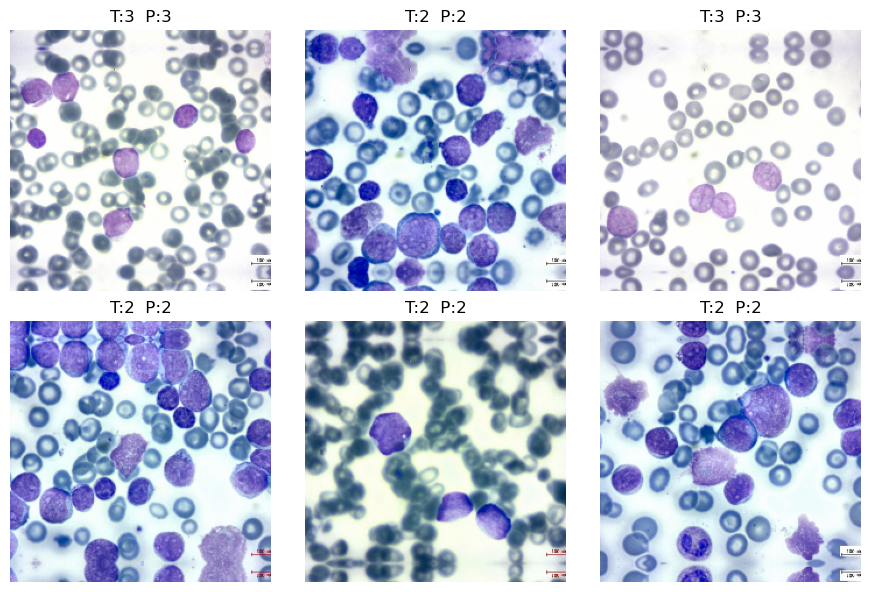

In [47]:
# Cell 9 – Đánh giá ConvNeXt-Tiny đã train

ARCH = "convnext_tiny"                 # kiến trúc
CKPT = "best_convnext_tiny.pth"        # file checkpoint vừa lưu

# 1) Khởi tạo mô hình đúng kiến trúc
model = timm.create_model(ARCH, num_classes=4)
model.load_state_dict(torch.load(CKPT, map_location=DEVICE))
model.to(DEVICE).eval()

# 2) Đánh giá trên test set
test_loss, test_acc = run_epoch(test_loader, train=False)
print(f"ConvNeXt-Tiny  | Test loss {test_loss:.4f} | Test acc {test_acc:.3f}")

# 3) Hiển thị 6 ảnh đầu (giữ nguyên phần vẽ)
# ------------------------------------------------------------------
import matplotlib.pyplot as plt, numpy as np
xb, yb = next(iter(test_loader))
with torch.no_grad():
    preds = model(xb.to(DEVICE)).argmax(1).cpu()

imgs = xb.numpy().transpose(0,2,3,1) * np.array(std) + np.array(mean)
imgs = np.clip(imgs, 0, 1)

plt.figure(figsize=(9,6))
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(imgs[i]); plt.axis("off")
    plt.title(f"T:{yb[i]}  P:{preds[i].item()}")
plt.tight_layout(); plt.show()


=== Classification Report ===
                         precision    recall  f1-score   support

                 Benign      1.000     1.000     1.000        51
[Malignant] early Pre-B      1.000     1.000     1.000        98
      [Malignant] Pre-B      1.000     1.000     1.000        96
      [Malignant] Pro-B      1.000     1.000     1.000        76

               accuracy                          1.000       321
              macro avg      1.000     1.000     1.000       321
           weighted avg      1.000     1.000     1.000       321



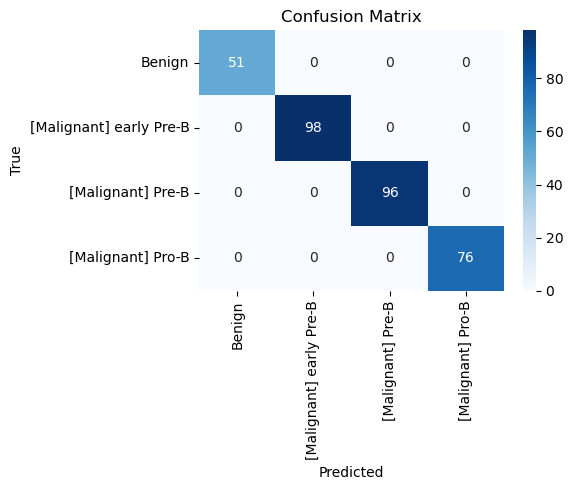

MCC   : 1.000
Kappa : 1.000
ROC-AUC (macro OVO): 1.000


In [48]:
from sklearn.metrics import (classification_report, confusion_matrix,
                             matthews_corrcoef, cohen_kappa_score,
                             roc_auc_score)
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# ---------------------------------------------------------------
# 1) Gom toàn bộ test set để lấy y_true, y_pred, y_prob
y_true, y_pred, y_prob = [], [], []

model.eval()
with torch.no_grad():
    for xb, yb in test_loader:
        logits = model(xb.to(DEVICE))
        y_true.append(yb.cpu().numpy())
        y_pred.append(logits.argmax(1).cpu().numpy())
        y_prob.append(torch.softmax(logits, dim=1).cpu().numpy())

y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)
y_prob = np.concatenate(y_prob)         # shape (N, 4)

# ---------------------------------------------------------------
# 2) Classification report (Precision / Recall / F1 per class)
target_names = list(label2idx.keys())
print("=== Classification Report ===")
print(classification_report(y_true, y_pred, target_names=target_names, digits=3))

# ---------------------------------------------------------------
# 3) Confusion-matrix (hiển thị heat-map)
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel("Predicted"); plt.ylabel("True"); plt.title("Confusion Matrix")
plt.tight_layout(); plt.show()

# ---------------------------------------------------------------
# 4) Các chỉ số bổ sung
mcc   = matthews_corrcoef(y_true, y_pred)
kappa = cohen_kappa_score(y_true, y_pred)
roc_auc = roc_auc_score(y_true, y_prob, multi_class="ovo", average="macro")

print(f"MCC   : {mcc:.3f}")
print(f"Kappa : {kappa:.3f}")
print(f"ROC-AUC (macro OVO): {roc_auc:.3f}")

# Save model

In [ ]:
# Cell 10 – Lưu model và thông tin training

# 1) Tạo folder 'models' nếu chưa tồn tại để lưu model
from pathlib import Path
model_dir = Path("models")
model_dir.mkdir(exist_ok=True)

# 2) Đặt tên file dựa trên timestamp hoặc epoch/accuracy
import time
timestamp = time.strftime("%Y%m%d-%H%M%S")
model_path = model_dir / f"resnet18_cleaned_{timestamp}.pth"

# 3) Lưu toàn bộ state_dict (weights) của model
#    Giả sử bạn đã train xong và checkpoint tốt nhất nằm ở 'best_resnet18_cleaned.pth'
#    Nếu bạn muốn lưu lại model cuối cùng (không nhất thiết là best), thay bằng model.state_dict()
best_checkpoint = Path("best_resnet18_cleaned.pth")
if best_checkpoint.exists():
    # Lưu bản best
    saved = model_dir / f"best_resnet18_cleaned_{timestamp}.pth"
    Path("models").mkdir(exist_ok=True)
    torch.save(torch.load(best_checkpoint, map_location="cpu"), saved)
    print(f"✓ Saved best checkpoint to {saved}")
else:
    # Lưu model hiện tại (cuối epoch cuối) nếu không có file best
    torch.save(model.state_dict(), model_path)
    print(f"✓ Saved current model state_dict to {model_path}")

# 4) (Tuỳ chọn) Lưu thêm thông tin mean/std và label2idx để dễ load lại
meta = {
    "mean": mean,
    "std": std,
    "label2idx": label2idx,
    "IMG_SIZE": IMG_SIZE,
    "BATCH_SIZE": BATCH_SIZE,
    "EPOCHS": EPOCHS,
    "LR": LR
}
meta_path = model_dir / f"metadata_{timestamp}.json"
with open(meta_path, "w") as f:
    json.dump(meta, f, indent=2)
print(f"✓ Saved metadata to {meta_path}")